?  =  variable name, possibly with indexing/slicing  
??? = function / class name  
?????? = complex expression containing variables, functions etc  
???B??? = complex expression that must contain "B"  

# Using behavior to predict neural activity

These groups of neurons that are not stimulus-selective, what are they doing? Maybe they are related to the behavior of the mouse?

If that's the case we need some low-dimensional representation of the behavior - we can't predict using 1 million pixels of video data - that's an underconstrained problem.

# 1. Load in data + behavior

In [2]:
# this cell imports all the functions and data we need
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
from scipy.stats import zscore
%matplotlib inline 

# folder where data is 
root = '/home/neudata/data/meso/'
mouse_name = 'TX39'

spks = np.load(os.path.join(root, mouse_name, 'suite2p/combined/spks.npy'))
stat = np.load(os.path.join(root, mouse_name, 'suite2p/combined/stat.npy'), allow_pickle=True)
print('total neurons %d'%len(stat))

S = zscore(spks,axis=1)
del spks # delete spks to clear memory

total neurons 18795


Load in behavioral data

In [3]:
# BEHAVIORAL DATA
proc   = np.load(os.path.join(root, mouse_name, 'cam1_TX39_2019_05_31_1_proc_resampled.npy'), allow_pickle=True)
proc   = proc.item() # non-array variables need to be accessed this way

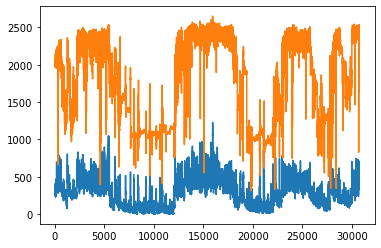

In [19]:
# what are the keys in proc? 
plt.plot(proc['pupil']['area'].flatten())
plt.plot(proc['blink'].flatten()/200)

In [6]:
proc['pupil'].keys(

dict_keys(['area', 'com'])

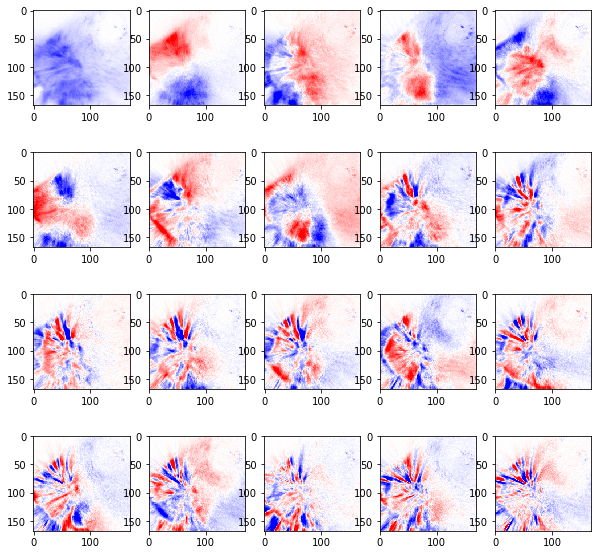

In [8]:
# show the first spatial motion SVD (and second, etc)
fig = plt.figure(figsize=(10,10))
for i in range(20):
    ax = fig.add_subplot(4,5,i+1)
    ax.imshow(proc['motMask'][i], cmap='bwr', vmin=-.02, vmax=.02)

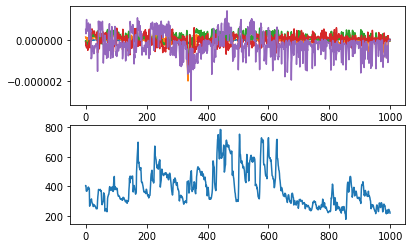

In [27]:
motSVD = proc['motSVD']
parea  = proc['pupil']['area'][0].copy()

# plot the first 1000 samples of the motion SVD
plt.subplot(2,1,1)
plt.plot(motSVD[:5,:1000].T / (motSVD[:5,:]**2).sum(axis=1))

# same for pupil area
plt.subplot(2,1,2)
plt.plot(parea[:1000])
plt.show()

In [20]:
proc['motSVD'].shape

(500, 30766)

# Bin neural and behavioral data + compute neural PCA

We will bin the neural activity to do the PCA and the behavior (1 second bins)

In [28]:
# bin data
tbin = int(3)
NT = motSVD.shape[1]
nt = int(np.floor(NT/tbin))
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
parea  -= np.nanmean(parea)
parea[np.isnan(parea)] = 0

beh = np.reshape(motSVD[:,:nt*tbin], (motSVD.shape[0], nt, tbin)).mean(axis=-1)
pup = np.reshape(parea[:nt*tbin], (nt, tbin)).mean(axis=-1)

# using this format bin S
# Sbin = ?
Sbin = np.reshape(S[:,:nt*tbin], (S.shape[0], nt, tbin)).mean(axis=-1)

Take principal components of neural data (as previously)

(18795, 256)


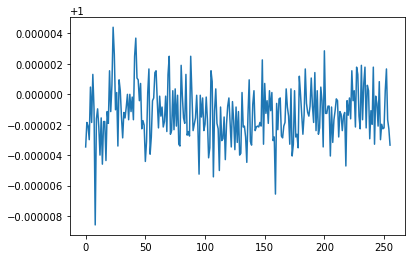

In [31]:
from sklearn.decomposition import PCA

# use PCA to get the top 256 neural components. The components must be spatial (by neurons)
model_pca = PCA(n_components=256).fit(Sbin.T) # 
U = model_pca.components_.T # neural components

# check the shape
print(U.shape)

# check that the Us are normalized to unit norm
plt.plot(np.sum(U**2, axis=0))

In [32]:
V = U.T @ Sbin # now project the binned data onto the spatial components. Figure out which transpose works! 
print(V.shape)

(256, 10255)


# Prediction of neural PCs

Now let's predict these neural PC's using our behavioral measures. But FIRST we need to split the data into train and test segments.

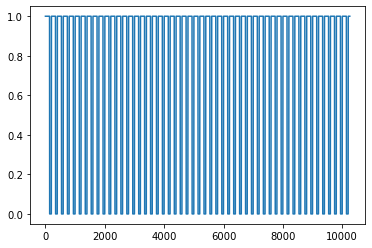

In [35]:
# split into train-test
# * use interleaved segments *
nlen   = 200 
itrain = np.remainder(np.arange(nt), nlen) < int(200*.70) # make 70% of the trials be training trials
itest  = ~itrain # what is not train is test

plt.plot(itrain)
plt.show()

In [33]:
np.remainder(np.arange(0,11),5)

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0])

Can you determine how I did the split above? Why might I have split into segments rather than randomly interleaving time-points?

# Prediction with behavioral variables

Use linear regression to perform the prediction, predict $Y$ using $X$:

$$ A = (X_\text{train}X_\text{train}^\top)^{-1} (X_\text{train} Y_\text{train}^\top)$$

$X$ is behavioral components by time, $Y$ is neural components by time. If you want to L2 regularize the linear regression:

$$ A = (X_\text{train}X_\text{train}^\top + \lambda I)^{-1} (X_\text{train} Y_\text{train}^\top)$$

Then the prediction on time points is:

$$ \hat Y_\text{test} = A^\top X_\text{test} $$

In [40]:
#### PREDICT USING PUPIL WITH LINEAR REGRESSION

X = pup[itrain]
X -= X.mean()
COV = X @ X.T # determine the covariance of the one-dimensional input X
print(COV)

A = 1/COV * (X @ V[:,itrain].T) # multiply training timepoints of pupil and neural PCs
print(A)

287055217.2668781
[ 1.64250357e-02  2.59738393e-02 -1.09714143e-02  5.71286533e-03
  8.22929931e-03 -3.72059182e-03  6.77067412e-03  2.40086435e-03
  5.22082774e-04  3.38876851e-03 -9.74211830e-04 -5.45934763e-04
  2.48955867e-03  8.62710013e-04 -1.68445792e-03  7.69942442e-04
 -1.79795895e-03  1.17934823e-03  1.49063501e-03  1.50338038e-03
 -3.60443313e-04 -7.93576965e-04  5.96113360e-04 -3.85447142e-06
 -1.51447692e-03  8.78847763e-04  9.92227308e-05 -2.21227737e-05
  1.45403895e-04  1.01317700e-03 -3.29919114e-04 -2.32215119e-04
  5.81795315e-04  7.54286383e-04  1.03310696e-04  3.84618410e-04
 -1.67410805e-03 -5.22634058e-04  1.68265090e-04  1.40510558e-03
  1.01877978e-03  1.43488951e-03  3.53788218e-04  1.19672548e-04
  8.79628550e-05  8.52646229e-04 -5.19712922e-05  4.53019792e-04
  5.55616297e-04  7.88492914e-04  3.53678724e-04 -4.38833892e-05
 -1.31501274e-04  7.31179356e-05 -6.61191387e-04  7.77455445e-04
 -5.80716925e-04 -5.21283015e-04  5.18066032e-04 -2.07935669e-04
  2.623

In [43]:
A.shape

(256,)

In [42]:
# what is the explained variance on test timepoints?
Xtest  = pup[itest]
Vpredp = A[:,np.newaxis] * Xtest[np.newaxis,:] # predict on test points

resid  = V[:,itest] - Vpredp # what are the unexplained residuals of the prediction? 

varexp_pupil = 1 - np.sum(resid**2, axis=1) / np.sum(V[:,itest]**2, axis=1)
print(varexp_pupil)

[ 1.27476401e-01  3.70018050e-01  4.44625928e-02  3.08872980e-02
  1.30031816e-01  4.31949575e-02  1.44614361e-02  8.37401469e-03
  2.77950636e-03  9.83130751e-03 -2.36234392e-03  1.32135442e-03
  4.84646138e-03 -1.68313041e-03  2.41210113e-02  5.54680978e-03
 -2.06683793e-02  1.11793387e-03  1.57215789e-02 -1.84082612e-02
 -2.50214236e-03  1.22420054e-02 -1.80369557e-03  2.08079533e-05
  1.80776519e-04 -5.56725515e-03 -1.51629561e-04 -1.36200864e-05
 -1.22354440e-04 -2.77986991e-03 -1.98477458e-03  2.61347221e-03
 -3.74602508e-03 -3.32349460e-03 -5.90780076e-05  2.11041247e-03
 -2.99710379e-02 -4.77794365e-03  8.40267783e-04 -2.54070198e-02
 -7.00633350e-03 -1.98939107e-02 -2.81018936e-03  3.18845456e-04
 -1.00215573e-03  2.01802999e-05 -4.88915273e-04 -1.44107007e-04
 -2.19516196e-03 -1.97848149e-03 -1.60252437e-03 -2.48774441e-04
 -5.30498587e-04 -2.52774265e-04  5.05892724e-03  1.20167869e-03
  8.71848435e-04  1.74457298e-03 -5.89470167e-04  5.61118632e-04
  1.89052211e-03  3.67927

In [47]:
#### PREDICT USING BEHAVIOR PCs 
## regularized linear regression from behavior to neural PC's

# covariance of inputs
covM  = beh[:,itrain] @ beh[:,itrain].T
lam   = 1e6 # regularizer
covM  = covM + lam*np.eye(beh.shape[0]) # add the regularizer

# covariance between behavior and neural data
covMV = beh[:,itrain] @ V[:,itrain].T 

# we need to solve for x: covM * x = covMV
A     = np.linalg.solve(covM, covMV)

Vpred = A.T @ beh[:,itest]
resid = V[:,itest] - Vpred # what are the unexplained residuals of the prediction? 

varexp = 1 - np.sum(resid**2, axis=1) / np.sum(V[:,itest]**2, axis=1)

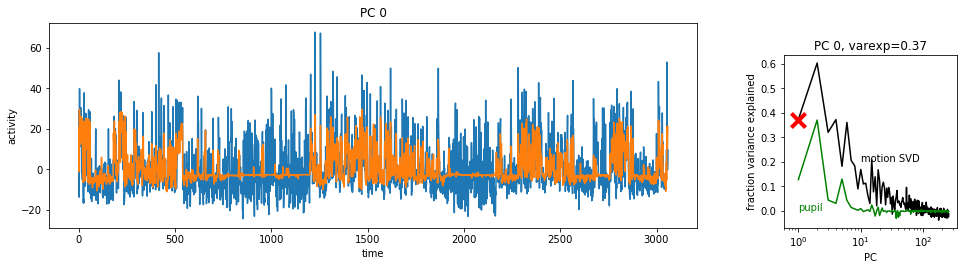

In [48]:
# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(V[ipc,itest])
ax.plot(Vpred[ipc])
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')

ax = fig.add_axes([0.9,.05, .2, .8])
ax.semilogx(np.arange(1,varexp.size+1), varexp, color='k')
ax.scatter(ipc+1, varexp[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp.size+1), varexp_pupil, color=[0.,.5,0])
ax.text(1,0,'pupil',color=[0,.5,0])
ax.text(10,0.2,'motion SVD')
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp[ipc]))
plt.show()

# Sort neurons with rastermap

Let's see how well the behavioral prediction "looks". First let's sort the neural activity by rastermap, then use the sorting to sort the prediction of the neural activity.

In [ ]:
# make sorting of neurons with rastermap
from rastermap import Rastermap

# fit a rastermap model to S with one component and n_X=100, 
model = ??????

Now let's sort by rastermap and smooth over neurons

In [ ]:
# SMOOTHED NEURAL ACTIVITY
# this function performs a running average filter over the first dimension of X
def running_average(X, nbin = 100):
    Y = np.cumsum(X, axis=0)
    Y = Y[nbin:, :] - Y[:-nbin, :]
    return Y

# sort the neurons by the embedding dimension of the model
isort = ???embedding???

Sfilt = Sbin[isort,:] # resort Sbin
Sfilt = running_average(Sfilt) # smoothing
Sfilt = zscore(Sfilt, axis=1)

Let's sort the behavioral prediction by rastermap and smooth over neurons.

In [ ]:
# go from PC prediction to single neuron prediction
# U is the neurons by components PC matrix
# Vpred is our prediction of the components

Spred = ? @ ? # what is the prediction of the neurons? this matrix should number of neurons BY number of test points
Sfilt_pred = running_average(Spred[isort, :]) # re-sort the prediction according to the rastermap, and smooth
Sfilt_pred = zscore(Sfilt_pred, axis=1) 

In [ ]:
# make a rastermap of activity with prediction

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(2,1,1)
ax.imshow(Sfilt[:, itest[:500]], vmin = -1, vmax=3, aspect='auto', cmap = 'gray_r')
ax.set_xlabel('time')
ax.set_ylabel('neurons')
ax.set_title('neural activity (test set)')

ax = fig.add_subplot(2,1,2)
ax.imshow(Sfilt_pred[:,:500], vmin = -1, vmax=3, aspect='auto', cmap = 'gray_r')
ax.set_xlabel('time')
ax.set_ylabel('neurons')
ax.set_title('behavior prediction (test set)')

plt.show()

In [ ]:
# how good is the prediction across the rastermap?

# Sfilt and Sfilt_pred contains neural activity/prediction smoothed across neurons.
# Pick every 50th row . It will contain the average of 100 neurons with similar activity. 
Sp      = ?????? # choose only testing timepoints to match the size of Sp_pred
Sp_pred = ?????? 

cc = np.zeros(nn)
for j in range(nn):
    C0 = np.corrcoef(Sp[j,:], Sp_pred[j,:])
    cc[j] = C0[0,1]

In [ ]:
# prediction quality across the rastermap

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(cc)
ax.set_ylim([0,1])
ax.set_ylabel('correlation btw/ pred and true')
ax.set_xlabel('depth on rastermap')
plt.show()